In [1]:
# pip install xgboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
    confusion_matrix, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


## Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
df_logins = pd.read_json('logins.json')
# Check head of data
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Create a new column with a value of 1 for each login event
df_logins['count'] = 1

In [5]:
# Convert the 'login_time' column to Pandas datetime format
df_logins['login_time'] = pd.to_datetime(df_logins['login_time'], unit='s')

In [6]:
# Set the 'login_time' column as the new index for the DataFrame and select only the 'count' column
df_logins = df_logins.set_index('login_time')

In [7]:
# Resample data in 15-minute increments and aggregate with sum
df_15min = df_logins.resample('15T').sum()

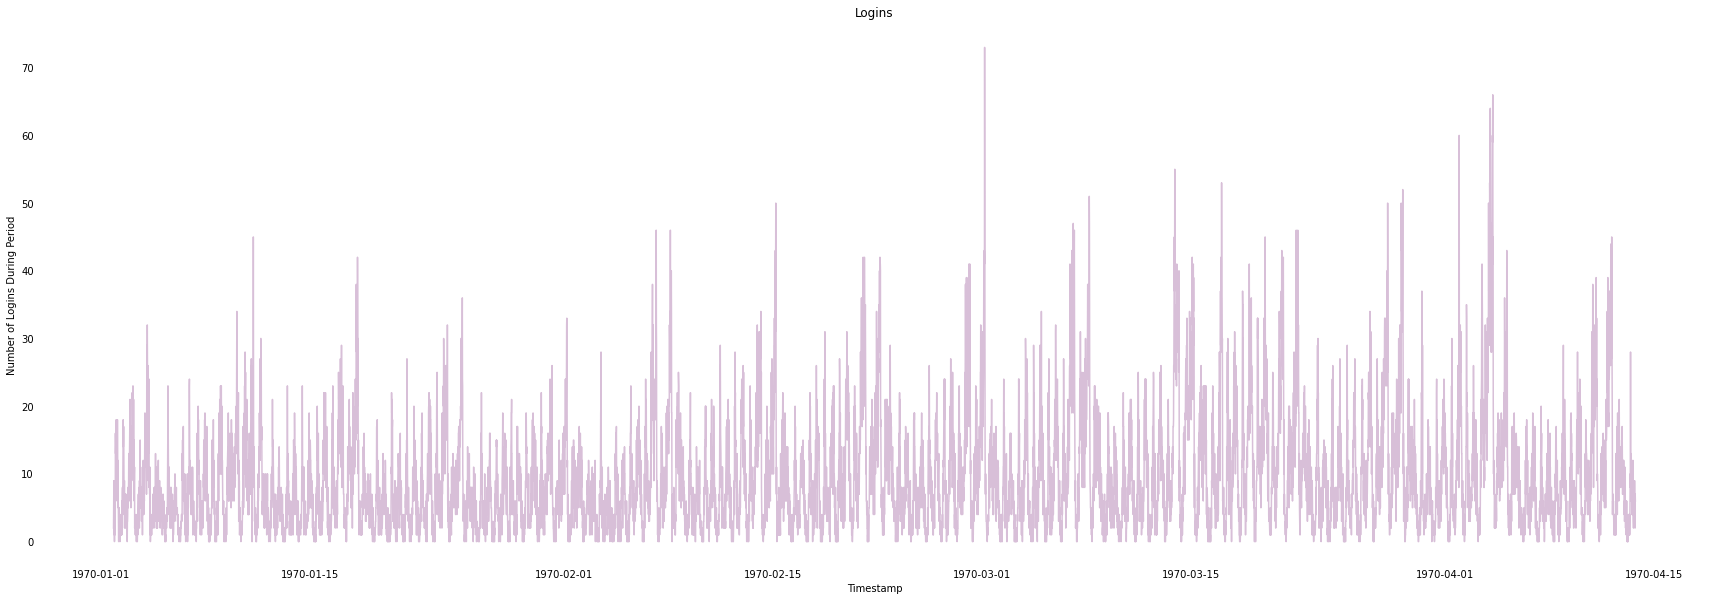

In [8]:
# Set the figsize
plt.figure(figsize=(30, 10))

# Plot the data
plt.plot(df_15min.index, 'count', data=df_15min, linestyle='-', color='thistle')

# Remove the spines of the plot & little ticks on the x-axis & y-axis
sns.despine(bottom=True, left=True)
plt.tick_params(which='both', length=0)

# Add labels and legend
plt.title('Logins')
plt.xlabel('Timestamp')
plt.ylabel('Number of Logins During Period')

# Show the plot
plt.show()

It's very hard to see what's going on. I'm going to look at a larger chunck size.

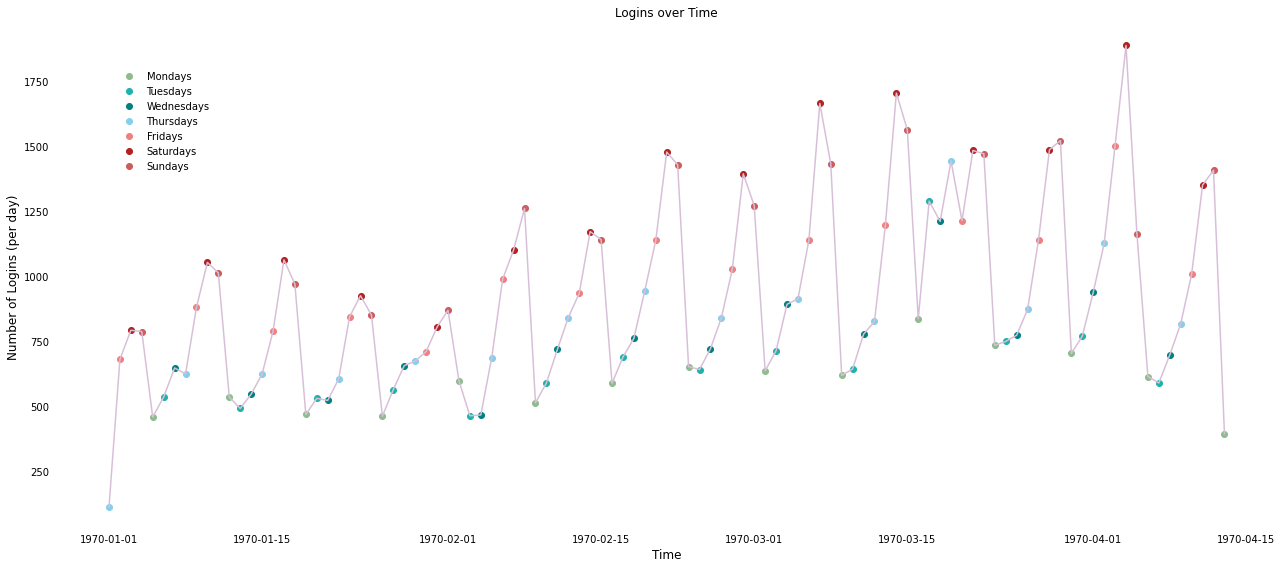

In [9]:
daily = df_logins.resample('D').sum()
mondays = daily[daily.index.weekday == 0]
tuesdays = daily[daily.index.weekday == 1]
wednesdays = daily[daily.index.weekday == 2]
thursdays = daily[daily.index.weekday == 3]
fridays = daily[daily.index.weekday == 4]
saturdays = daily[daily.index.weekday == 5] # 5 represents Saturday
sundays = daily[daily.index.weekday == 6] # 6 represents Sunday

# Set the figsize
plt.figure(figsize=(18, 8))

plt.scatter(mondays.index, mondays['count'], label = 'Mondays', color='darkseagreen')
plt.scatter(tuesdays.index, tuesdays['count'], label = 'Tuesdays', color='lightseagreen')
plt.scatter(wednesdays.index, wednesdays['count'], label = 'Wednesdays', color='teal')
plt.scatter(thursdays.index, thursdays['count'], label = 'Thursdays', color='skyblue')
plt.scatter(fridays.index, fridays['count'], label = 'Fridays', color='lightcoral')
plt.scatter(saturdays.index, saturdays['count'], label = 'Saturdays', color='firebrick')
plt.scatter(sundays.index, sundays['count'], label = 'Sundays', color='indianred')
plt.plot(daily.index, daily['count'], linestyle='-', color='thistle')

# Remove the spines of the plot & little ticks on the x-axis & y-axis
sns.despine(bottom=True, left=True)
plt.tick_params(which='both', length=0)


plt.xlabel('Time', fontsize = 12)
plt.ylabel('Number of Logins (per day)', fontsize = 12)
plt.title('Logins over Time', fontsize = 12)

plt.legend(loc=(0.05,0.7), fontsize = 10, frameon=False)
plt.tight_layout()

### There is definitely increased traffic on the weekends. Monday is a pretty consistent low point with an upward trajectory throughout the week peaking at Saturday or Sunday. 

In [10]:
df_hourly = df_logins.resample('H').sum()
df_hourly.head()

,count
login_time,
1970-01-01 20:00:00,24
1970-01-01 21:00:00,9
1970-01-01 22:00:00,21
1970-01-01 23:00:00,58
1970-01-02 00:00:00,53


In [11]:
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day'] = df_hourly.index.weekday

df_hourly = df_hourly.rename(columns={'count': 'login_count'})
df_hourly.head()

,login_count,hour,day
login_time,,,
1970-01-01 20:00:00,24,20,3
1970-01-01 21:00:00,9,21,3
1970-01-01 22:00:00,21,22,3
1970-01-01 23:00:00,58,23,3
1970-01-02 00:00:00,53,0,4


In [12]:
df_hourly.head()

,login_count,hour,day
login_time,,,
1970-01-01 20:00:00,24,20,3
1970-01-01 21:00:00,9,21,3
1970-01-01 22:00:00,21,22,3
1970-01-01 23:00:00,58,23,3
1970-01-02 00:00:00,53,0,4


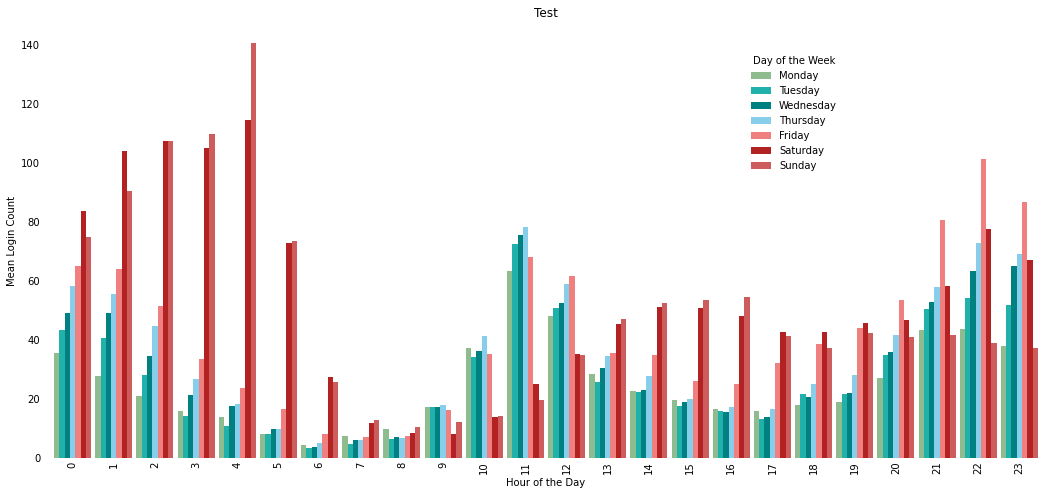

In [13]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = ['darkseagreen', 'lightseagreen', 'teal', 'skyblue', 'lightcoral', 'firebrick', 'indianred']

grouped = df_hourly.groupby(['hour', 'day']).mean()
grouped_unstacked = grouped.unstack()

ax = grouped_unstacked.plot(kind='bar', figsize=(18, 8), width=0.9, color=colors)

# Remove the spines of the plot & little ticks on the x-axis & y-axis
sns.despine(bottom=True, left=True)
plt.tick_params(which='both', length=0)

ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Mean Login Count')
ax.legend(labels=days, loc=(0.7,0.65), fontsize=10, frameon=False, title='Day of the Week')
ax.set_title('Test', fontsize=12)
plt.show()

In [14]:
grouped_unstacked.head(20)

login_count                                                          \
day            0          1          2          3          4           5   
hour                                                                       
0      35.400000  43.357143  49.071429  58.285714  65.000000   83.600000   
1      27.600000  40.428571  49.000000  55.500000  63.800000  104.133333   
2      20.800000  28.142857  34.428571  44.642857  51.400000  107.200000   
3      15.733333  14.142857  21.357143  26.785714  33.466667  104.933333   
4      13.733333  10.642857  17.500000  18.214286  23.533333  114.600000   
5       8.066667   8.071429   9.642857   9.714286  16.333333   72.866667   
6       4.400000   3.285714   3.428571   4.785714   8.066667   27.200000   
7       7.400000   4.571429   6.000000   5.785714   7.000000   11.866667   
8       9.800000   6.285714   7.071429   6.785714   7.266667    8.466667   
9      17.066667  17.285714  17.142857  17.928571  16.000000    7.866667   
10     37.200000  34.214286  36.285714  41.285714  35.133333   13.600000   
11     63.133333  72.500000  75.500000  78.357143  67.933333   24.800000   
12     48.133333  50.714286  52.285714  58.857143  61.733333   35.200000   
13     28.400000  25.785714  30.285714  34.571429  35.533333   45.266667   
14     22.466667  22.071429  22.785714  27.714286  34.800000   51.000000   
15     19.533333  17.642857  18.785714  20.000000  26.000000   50.866667   
16     16.600000  15.642857  15.285714  17.285714  24.800000   47.866667   
17     15.866667  13.071429  13.714286  16.571429  32.000000   42.733333   
18     17.800000  21.642857  20.500000  25.071429  38.466667   42.533333   
19     18.714286  21.500000  21.857143  28.000000  43.866667   45.600000   

                  
day            6  
hour              
0      74.866667  
1      90.333333  
2     107.200000  
3     109.800000  
4     140.466667  
5      73.466667  
6      25.466667  
7      12.800000  
8      10.200000  
9      12.000000  
10     14.000000  
11     19.466667  
12     34.800000  
13     46.933333  
14     52.400000  
15     53.466667  
16     54.533333  
17     41.200000  
18     37.133333  
19     42.133333

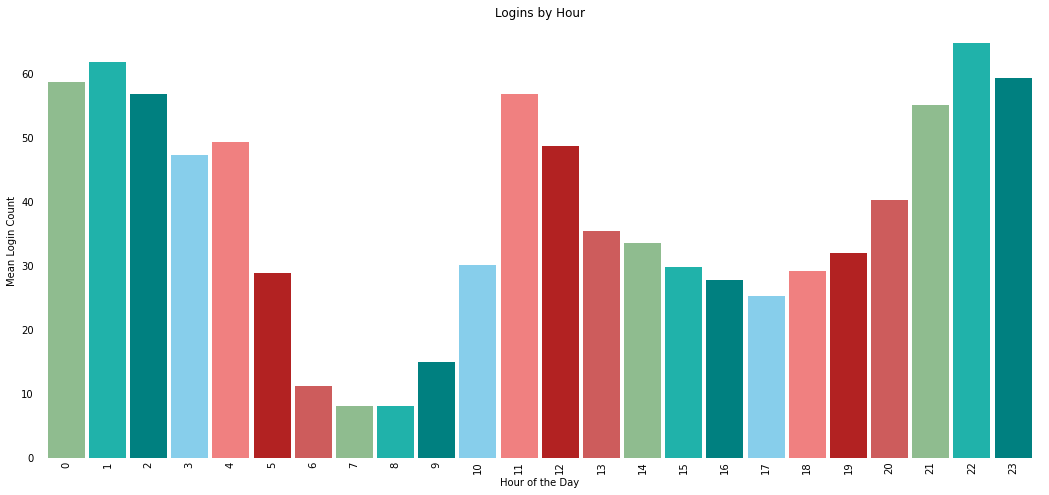

In [15]:
grouped_hr = df_hourly.groupby('hour')['login_count'].mean()
ax = grouped_hr.plot(kind='bar', figsize=(18, 8), width=0.9, color=colors)

# Remove the spines of the plot & little ticks on the x-axis & y-axis
sns.despine(bottom=True, left=True)
plt.tick_params(which='both', length=0)

ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Mean Login Count')
ax.set_title('Logins by Hour', fontsize=12)
plt.show()

In [16]:
# Compute the rolling average of login counts over a 24-hour window
rolling_avg = df_15min.rolling(window=96).mean()

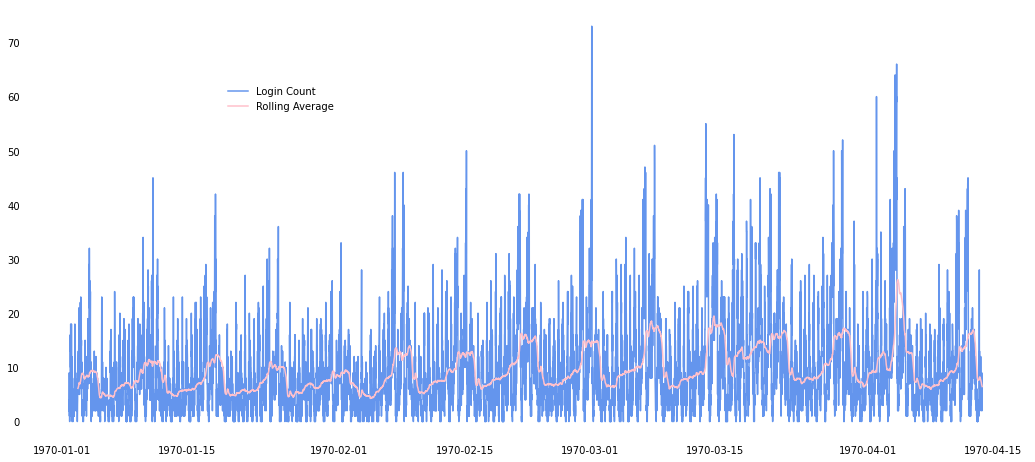

In [17]:
# Set the figsize
plt.figure(figsize=(18, 8))

# Plot the login counts and rolling average on the same plot
plt.plot(df_15min.index, 'count', data=df_15min, linestyle='-', color='cornflowerblue')
plt.plot(df_15min.index, 'count', data=rolling_avg, linestyle='-', color='pink')
plt.legend(['Login Count', 'Rolling Average'], frameon=False, loc=(0.2,0.75), fontsize=10)

# Remove the spines of the plot & little ticks on the x-axis & y-axis
sns.despine(bottom=True, left=True)
plt.tick_params(which='both', length=0)

plt.show()

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

**Question:** <br>
1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? 

**Answer:** <br>
I would look at the increase in the number of rides that driver partners make across the toll between the citities as the key measure of success. 

This metric would be useful as it would directly reflect whether the reimbursement of toll costs has increased the number of driver partners who are willing to serve customers in the neighboring city, by measuring the number of times they cross the toll bridge. I would also look at the patterns and trends of toll bridge crossings. Are certain days/times more common? 

Additionally, it's possilbe that drivers have already adapted and have a set schedule. Drivers in Gotham might be used to working night shifts and drivers in Metropolis might be used to day shifts. It might take a while for drivers to shift their patterns.

**Question:** <br>
2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: <br>
    a) how you will implement the experiment <br>
    b) what statistical test(s) you will conduct to verify the significance of the observation <br>
    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

**Answer:**<br>
a) Experiment design:

First, I would need to conduct a randomized controlled trial to test if the reimbursed toll costs encouraged drivers to serve both cites by randomly selecting a sample of driver partners from each city and then assigning each driver partner to either the treatment group or the control group. 

The treatment group will receive a reimbursement of all toll costs incurred while crossing the toll bridge between the two cities. The control group will not receive any reimbursement.


Then monitor the number of toll bridge crossings made by drivers in both the treatment and control groups for a predetermined period (e.g., two weeks) before and after the reimbursement program is introduced. Compare the average number of toll bridge crossings made by driver partners in the treatment and control groups before and after the reimbursement program is introduced.

This is an important step rather than rolling out the program to all drivers as many outside factors could impact the results. 

**Answer**<br>
b) Statistical tests:

To verify the significance of the observation, I would conduct a hypothesis test to determine whether the difference in toll bridge crossings made by the treatment and control groups is statistically significant. Then use a t-test to compare the means of the two groups. The null hypothesis would be that there is no difference in the average number of toll bridge crossings made by the treatment and control groups, and the alternative hypothesis would be that there is a difference. I would use a level of significance of 0.05.

**Answer:**<br>
c) Interpretation and recommendations:

If the results of the t-test show a statistically significant difference between the average number of toll bridge crossings made by the treatment and control groups, I would conclude that the reimbursement program has been effective in encouraging driver partners to serve both cities. In this case, I would recommend that the reimbursement program be continued and possibly expanded to include other incentives to further encourage driver partners to serve both cities.

**Answer:**<br>
Caveats: However, there are some caveats to consider. Firstly, the results of the experiment may not be generalizable to all driver partners in Gotham and Metropolis, as the sample size may not be representative of the entire population. Secondly, other factors may influence the number of toll bridge crossings made by driver partners, such as weather conditions or events happening in either city, which may not be controlled for in the experiment. Finally, the cost of the reimbursement program and its impact on Ultimate's profitability should be considered when making recommendations to the city operations team.

## Part 3 ‐ Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

In [18]:
df = pd.read_json('ultimate_data_challenge.json')

**1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?**

In [19]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [21]:
# Change signup date and last trip date to datetime.
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [22]:
df['phone'] = df['phone'].fillna('Unknown')

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00


In [24]:
# Replace NaNs with mean in avg_rating_of_driver column
avg_rating_of_driver_mean = df['avg_rating_of_driver'].mean()
df['avg_rating_of_driver'].fillna(avg_rating_of_driver_mean, inplace=True)

# Replace NaNs with mean in avg_rating_by_driver column
avg_rating_by_driver_mean = df['avg_rating_by_driver'].mean()
df['avg_rating_by_driver'].fillna(avg_rating_by_driver_mean, inplace=True)

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,50000.0,4.601559,0.564977,1.0,4.50,4.70,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,50000.0,4.778158,0.445753,1.0,4.70,5.00,5.00,5.00


In [26]:
df.sort_values(by='trips_in_first_30_days', ascending=False).head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8
99,Astapor,73,2014-01-27,4.9,1.00,2014-03-05,Android,0.0,True,89.7,2.86,4.9
3030,Winterfell,71,2014-01-06,4.9,1.06,2014-06-28,iPhone,2.9,True,85.9,2.32,4.8
29070,Astapor,63,2014-01-10,4.0,1.07,2014-06-29,iPhone,7.3,True,83.3,1.45,4.6
48804,Astapor,58,2014-01-24,4.4,1.04,2014-06-05,iPhone,3.1,True,77.6,2.30,4.7
45489,Astapor,56,2014-01-28,4.8,1.01,2014-04-23,iPhone,1.3,True,78.8,3.65,4.4
36917,Winterfell,56,2014-01-26,4.8,1.01,2014-06-30,iPhone,2.2,False,73.1,3.51,4.8
29043,King's Landing,55,2014-01-22,4.8,1.03,2014-06-30,iPhone,4.8,True,66.5,3.39,4.6
17942,Winterfell,55,2014-01-07,4.6,1.03,2014-06-25,iPhone,5.3,True,68.0,3.27,4.7
31047,Winterfell,54,2014-01-25,4.9,1.10,2014-06-29,iPhone,9.1,True,83.0,2.19,4.5


In [27]:
# 125 trips seems suspicous. Let's drop it. 
df = df[df['trips_in_first_30_days'] <= 100]

In [28]:
df.sort_values(by='avg_surge', ascending=False).head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
13861,Winterfell,1,2014-01-01,1.000000,8.00,2014-01-01,iPhone,100.0,False,100.0,5.77,5.0
30477,Winterfell,1,2014-01-01,5.000000,5.75,2014-01-01,iPhone,100.0,False,100.0,1.98,5.0
19191,Winterfell,1,2014-01-10,5.000000,5.00,2014-01-11,Android,100.0,False,100.0,3.37,5.0
2817,Winterfell,0,2014-01-02,5.000000,5.00,2014-02-05,iPhone,100.0,False,100.0,3.18,5.0
49383,Winterfell,1,2014-01-10,4.601559,5.00,2014-01-11,iPhone,100.0,False,100.0,2.40,5.0
47052,Winterfell,1,2014-01-09,4.601559,5.00,2014-01-11,Android,100.0,False,100.0,2.96,5.0
21894,Winterfell,1,2014-01-10,4.601559,5.00,2014-01-11,Android,100.0,False,100.0,2.46,4.0
1405,Winterfell,1,2014-01-08,5.000000,4.75,2014-01-21,iPhone,100.0,False,100.0,6.46,5.0
10546,Winterfell,0,2014-01-03,4.601559,4.50,2014-06-21,iPhone,100.0,False,0.0,2.70,5.0
15334,Winterfell,0,2014-01-13,4.601559,4.50,2014-06-18,iPhone,100.0,False,100.0,1.40,5.0


In [29]:
df.sort_values(by='surge_pct', ascending=False).head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
42177,King's Landing,1,2014-01-18,3.000000,2.25,2014-01-20,iPhone,100.0,False,0.0,3.09,5.000000
2202,Winterfell,0,2014-01-18,4.601559,2.00,2014-05-11,iPhone,100.0,False,0.0,9.91,5.000000
31237,King's Landing,0,2014-01-30,5.000000,1.25,2014-04-13,Android,100.0,False,0.0,17.20,5.000000
1021,King's Landing,0,2014-01-23,4.601559,1.75,2014-06-13,iPhone,100.0,True,100.0,2.33,4.778158
45469,Winterfell,2,2014-01-10,4.601559,2.13,2014-02-08,Android,100.0,False,100.0,2.32,5.000000
11918,Astapor,1,2014-01-23,4.601559,2.25,2014-01-24,iPhone,100.0,False,100.0,2.32,5.000000
27885,Winterfell,0,2014-01-23,5.000000,1.25,2014-06-28,iPhone,100.0,False,0.0,7.68,5.000000
31239,Astapor,1,2014-01-15,5.000000,2.50,2014-01-16,iPhone,100.0,False,100.0,1.15,5.000000
5040,Astapor,1,2014-01-17,4.601559,2.50,2014-01-19,iPhone,100.0,False,0.0,1.19,1.000000
31245,King's Landing,0,2014-01-31,5.000000,1.25,2014-06-14,Android,100.0,False,0.0,0.38,5.000000


In [30]:
df.sort_values(by='avg_dist', ascending=False).head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
20701,Astapor,0,2014-01-25,4.601559,1.0,2014-06-26,Android,0.0,False,100.0,160.96,4.778158
534,King's Landing,0,2014-01-04,4.601559,1.0,2014-03-09,Unknown,0.0,False,0.0,129.89,5.000000
1302,Winterfell,1,2014-01-30,5.000000,1.0,2014-01-30,iPhone,0.0,False,100.0,79.69,5.000000
22290,Astapor,0,2014-01-12,5.000000,1.0,2014-06-26,iPhone,0.0,True,100.0,79.34,5.000000
47595,King's Landing,0,2014-01-25,5.000000,1.0,2014-06-09,iPhone,0.0,True,0.0,77.13,5.000000
36625,Astapor,2,2014-01-19,5.000000,1.0,2014-01-22,iPhone,0.0,False,100.0,73.88,3.000000
22096,Astapor,0,2014-01-17,4.601559,1.0,2014-05-01,iPhone,0.0,True,100.0,72.20,5.000000
1493,Astapor,1,2014-01-26,5.000000,1.0,2014-01-27,iPhone,0.0,False,100.0,72.08,5.000000
19197,Astapor,2,2014-01-17,4.700000,1.0,2014-05-14,iPhone,0.0,True,100.0,71.38,5.000000
42835,Winterfell,0,2014-01-10,5.000000,1.0,2014-06-28,Android,0.0,False,100.0,70.48,5.000000


In [31]:
# find the date the data was pulled
pull_date = df.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe 0= inactive, 1 = active
df['active_status'] = (df.last_trip_date > cut_off_day).astype('int')

# add dummies to categorical data
df = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])

In [32]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,0,1,0


In [33]:
num_active = df.active_status.sum()
percent_active = num_active / len(df.active_status) * 100
print(f'The percentage of active users is {round(percent_active, 2)}%.')

The percentage of active users is 36.62%.


**Answer:**<br>
The percentage of active users is 36.62%.

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [34]:
df.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active_status', 'city_Astapor',
       'city_King's Landing', 'city_Winterfell', 'phone_Android',
       'phone_Unknown', 'phone_iPhone', 'ultimate_black_user_False',
       'ultimate_black_user_True'],
      dtype='object')

In [35]:
# Define features and target (y)
X = df.drop(['active_status','signup_date', 'last_trip_date'], axis=1)
y = df.active_status

# Change uint8 data tpes to int
uint8_cols = X.select_dtypes(include='uint8').columns
X[uint8_cols] = X[uint8_cols].astype('int')

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=123)

# initialize a StandardScaler object and fit it on the training data
scaler = StandardScaler()
scaler.fit(X_train)

# apply the scaling transformation to both the training and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
# Create a logistic regression object
lr = LogisticRegression(class_weight='balanced', random_state=42)

# Train the model on the training data (scaled data)
lr.fit(X_train, y_train)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test)

# Calculate the metrics
lr_acc = round(accuracy_score(y_test, y_pred),2)
lr_prec = round(precision_score(y_test, y_pred),2)
lr_rec = round(recall_score(y_test, y_pred),2)
lr_f1 = round(f1_score(y_test, y_pred),2)
lr_roc_auc = round(roc_auc_score(y_test, y_pred),2)

# Print the metrics
print("Accuracy:", lr_acc)
print("Precision:", lr_prec)
print("Recall:", lr_rec)
print("F1 score:", lr_f1)
print("ROC-AUC score:", lr_roc_auc)

Accuracy: 0.71
Precision: 0.59
Recall: 0.67
F1 score: 0.62
ROC-AUC score: 0.7


In [45]:
import xgboost as xgb

# Create an XGBoost object
xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model on the training data
xgb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test)

# Calculate the metrics
xgb_acc = round(accuracy_score(y_test, y_pred),2)
xgb_prec = round(precision_score(y_test, y_pred),2)
xgb_rec = round(recall_score(y_test, y_pred),2)
xgb_f1 = round(f1_score(y_test, y_pred),2)
xgb_roc_auc = round(roc_auc_score(y_test, y_pred),2)

# Print the metrics
print("Accuracy:", xgb_acc)
print("Precision:", xgb_prec)
print("Recall:", xgb_rec)
print("F1 score:", xgb_f1)
print("ROC-AUC score:", xgb_roc_auc)

Accuracy: 0.79
Precision: 0.75
Recall: 0.67
F1 score: 0.7
ROC-AUC score: 0.77


In [47]:
import xgboost as xgb

# Create an XGBoost object
xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
}

# Create a GridSearchCV object
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy')

# Train the model on the training data
grid_xgb.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_xgb.best_params_
print(f'The best parameters are:{best_params}.')

# Train the model with the best hyperparameters on the training data
xgb = xgb.XGBClassifier(**best_params)
xgbl.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test)

# Calculate the metrics
tuned_acc = accuracy_score(y_test, y_pred)
tuned_prec = precision_score(y_test, y_pred)
tuned_rec = recall_score(y_test, y_pred)
tuned_f1 = f1_score(y_test, y_pred)
tuned_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", tuned_acc)
print("Precision:", tuned_prec)
print("Recall:", tuned_rec)
print("F1 score:", tuned_f1)
print("ROC-AUC score:", tuned_roc_auc)

The best parameters are:{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}.


AttributeError: 'XGBClassifier' object has no attribute 'XGBClassifier'

In [38]:
# # Create an XGBoost classifier object
# xgb_clf = xgb.XGBClassifier()

# # Define the hyperparameter grid
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200],
# }

# # Create a GridSearchCV object
# grid_clf = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy')

# # Fit the GridSearchCV object to the training data
# grid_clf.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding mean cross-validation score
# print("Best hyperparameters:", grid_clf.best_params_)
# print("Best mean cross-validation score:", grid_clf.best_score_)

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).